# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** and **Chapter 4 - Beyond Classical Search** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [ ]:
from search import *

C:\Users\Eshan\AppData\Local\Programs\Python\Python36\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Review

Here, we learn about problem solving. Building goal-based agents that can plan ahead to solve problems, in particular, navigation problem/route finding problem. First, we will start the problem solving by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms. Broadly, search algorithms are classified into two types:

* **Uninformed search algorithms**: Search algorithms which explore the search space without having any information about the problem other than its definition.
* Examples:
    1. Breadth First Search
    2. Depth First Search
    3. Depth Limited Search
    4. Iterative Deepening Search


* **Informed search algorithms**: These type of algorithms leverage any information (heuristics, path cost) on the problem to search through the search space to find the solution efficiently.
* Examples:
    1. Best First Search
    2. Uniform Cost Search
    3. A\* Search
    4. Recursive Best First Search

*Don't miss the visualisations of these algorithms solving the route-finding problem defined on Romania map at the end of this notebook.*

## Problem

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [2]:
%psource Problem

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor` and is the first method called when you create an instance of the class. `initial` specifies the initial state of our search problem. It represents the start state from where our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Given a graph state, it checks if it is a terminal state. If the state is indeed a goal state, value of `True` is returned. Else, of course, `False` is returned.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

We will use the abstract class `Problem` to define our real **problem** named `GraphProblem`. You can see how we define `GraphProblem` by running the next cell.

In [3]:
%psource GraphProblem

Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph. Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

In [4]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Hmm... say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [5]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

# Romania map visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [6]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's start the visualisations by importing necessary modules. We use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works.

In [7]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [8]:
# initialise a graph
G = nx.Graph()

# use this while labeling nodes in the map
node_labels = dict()
# use this to modify colors of nodes while exploring the graph.
# This is the only dict we send to `show_map(node_colors)` while drawing the map
node_colors = dict()

for n, p in romania_locations.items():
    # add nodes from romania_locations
    G.add_node(n)
    # add nodes to node_labels
    node_labels[n] = n
    # node_colors to color nodes while exploring romania map
    node_colors[n] = "white"

# we'll save the initial node colors to a dict to use later
initial_node_colors = dict(node_colors)
    
# positions for node labels
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_locations.items() }

# use this while labeling edges
edge_labels = dict()

# add edges between cities in romania map - UndirectedGraph defined in search.py
for node in romania_map.nodes():
    connections = romania_map.get(node)
    for connection in connections.keys():
        distance = connections[connection]

        # add edges to the graph
        G.add_edge(node, connection)
        # add distances to edge_labels
        edge_labels[(node, connection)] = distance

In [9]:
# initialise a graph
G = nx.Graph()

# use this while labeling nodes in the map
node_labels = dict()
# use this to modify colors of nodes while exploring the graph.
# This is the only dict we send to `show_map(node_colors)` while drawing the map
node_colors = dict()

for n, p in romania_locations.items():
    # add nodes from romania_locations
    G.add_node(n)
    # add nodes to node_labels
    node_labels[n] = n
    # node_colors to color nodes while exploring romania map
    node_colors[n] = "white"

# we'll save the initial node colors to a dict to use later
initial_node_colors = dict(node_colors)
    
# positions for node labels
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_locations.items() }

# use this while labeling edges
edge_labels = dict()

# add edges between cities in romania map - UndirectedGraph defined in search.py
for node in romania_map.nodes():
    connections = romania_map.get(node)
    for connection in connections.keys():
        distance = connections[connection]

        # add edges to the graph
        G.add_edge(node, connection)
        # add distances to edge_labels
        edge_labels[(node, connection)] = distance

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

In [10]:
def show_map(node_colors):
    # set the size of the plot
    plt.figure(figsize=(18,13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos = romania_locations, node_color = [node_colors[node] for node in G.nodes()])

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos = node_label_pos, labels = node_labels, font_size = 14)
    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos = romania_locations, edge_labels=edge_labels, font_size = 14)
    
    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1,prop={'size':16}, loc=(.8,.75))
    
    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

We can simply call the function with node_colors dictionary object to display it.

C:\Users\Eshan\AppData\Local\Programs\Python\Python36\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\Eshan\AppData\Local\Programs\Python\Python36\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\Eshan\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Eshan\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\rcsetup.py:152: UserW

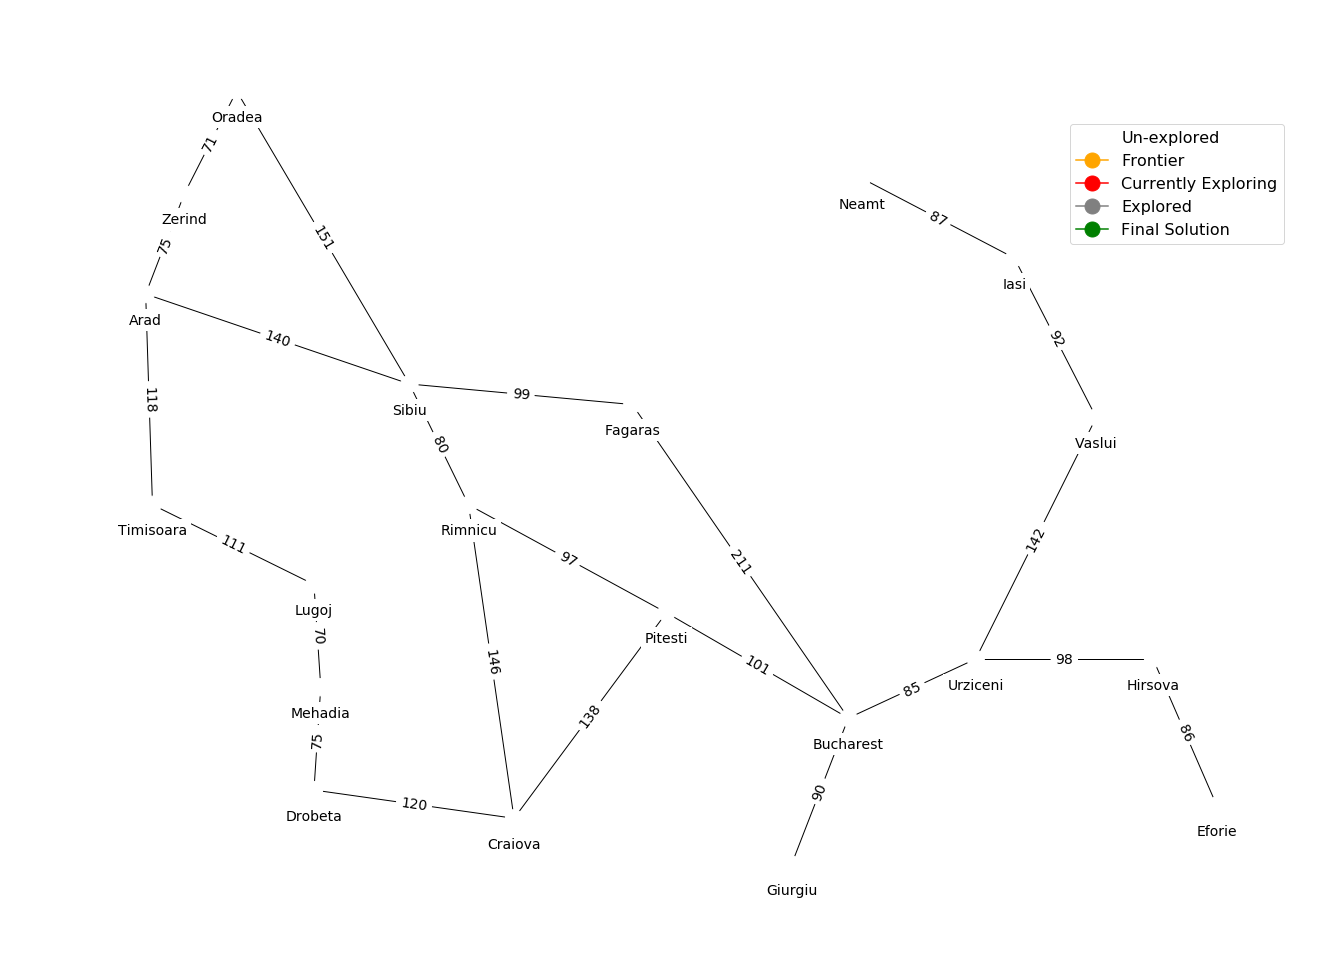

In [11]:
show_map(node_colors)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## Searching algorithms visualisations

In this section, we have visualisations of the following searching algorithms:

1. Breadth First Tree Search - Implemented
2. Depth First Tree Search
3. Depth First Graph Search
4. Breadth First Search - Implemented
5. Best First Graph Search
6. Uniform Cost Search - Implemented
7. Depth Limited Search
8. Iterative Deepening Search
9. A\*-Search - Implemented
10. Recursive Best First Search

We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

Now, we will define some helper methods to display interactive buttons and sliders when visualising search algorithms.

In [12]:
def final_path_colors(problem, solution):
    "returns a node_colors dict of the final path provided the problem and solution"
    
    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"  
    return final_colors


def display_visual(user_input, algorithm=None, problem=None):
    if user_input == False:
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(all_node_colors[iteration])
            except:
                pass
        def visualize_callback(Visualize):
            if Visualize is True:
                button.value = False
                
                global all_node_colors
                
                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(problem, solution))
                
                slider.max = len(all_node_colors) - 1
                
                for i in range(slider.max + 1):
                    slider.value = i
                     #time.sleep(.5)
        
        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration = slider)
        display(slider_visual)

        button = widgets.ToggleButton(value = False)
        button_visual = widgets.interactive(visualize_callback, Visualize = button)
        display(button_visual)
    
    if user_input == True:
        node_colors = dict(initial_node_colors)
        if algorithm == None:
            algorithms = {"Breadth First Tree Search": breadth_first_tree_search, "Breadth First Search": breadth_first_search, "Uniform Cost Search": uniform_cost_search, "A-star Search": astar_search}
            algo_dropdown = widgets.Dropdown(description = "Search algorithm: ", options = sorted(list(algorithms.keys())), value = "Breadth First Tree Search")
            display(algo_dropdown)
        
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(all_node_colors[iteration])
            except:
                pass
            
        def visualize_callback(Visualize):
            if Visualize is True:
                button.value = False
                
                problem = GraphProblem(start_dropdown.value, end_dropdown.value, romania_map)
                global all_node_colors
                
                if algorithm == None:
                    user_algorithm = algorithms[algo_dropdown.value]
                
#                 print(user_algorithm)
#                 print(problem)
                
                iterations, all_node_colors, node = user_algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(problem, solution))

                slider.max = len(all_node_colors) - 1
                
                for i in range(slider.max + 1):
                    slider.value = i
#                     time.sleep(.5)
                         
        start_dropdown = widgets.Dropdown(description = "Start city: ", options = sorted(list(node_colors.keys())), value = "Arad")
        display(start_dropdown)

        end_dropdown = widgets.Dropdown(description = "Goal city: ", options = sorted(list(node_colors.keys())), value = "Fagaras")
        display(end_dropdown)
        
        button = widgets.ToggleButton(value = False)
        button_visual = widgets.interactive(visualize_callback, Visualize = button)
        display(button_visual)
        
        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration = slider)
        display(slider_visual)


## Breadth first tree search

We have a working implementation in search module. But as we want to interact with the graph while it is searching, we need to modify the implementation. Here's the modified breadth first tree search.



In [13]:
def tree_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    #Adding first node to the queue
    frontier.append(Node(problem.initial))
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_search(problem, FIFOQueue())
    return(iterations, all_node_colors, node)

Now, we use ipywidgets to display a slider, a button and our romania map. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider. These two helper functions are the callback functions which are called when we interact with the slider and the button.



In [14]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Fagaras', romania_map)
display_visual(user_input = False, algorithm = breadth_first_tree_search, problem = romania_problem)

Widget Javascript not detected.  It may not be installed or enabled properly.


## Breadth first search

Let's change all the node_colors to starting position and define a different problem statement.

In [15]:
def breadth_first_search(problem):
    "[Figure 3.11]"
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = FIFOQueue()
    frontier.append(node)
    
    # modify the color of frontier nodes to blue
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
        
    explored = set()
    while frontier:
        node = frontier.pop()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [16]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = breadth_first_search, problem = romania_problem)

Widget Javascript not detected.  It may not be installed or enabled properly.


## Uniform cost search

Let's change all the node_colors to starting position and define a different problem statement.

In [17]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def uniform_cost_search(problem):
    "[Figure 3.14]"
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)

In [18]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = uniform_cost_search, problem = romania_problem)

Widget Javascript not detected.  It may not be installed or enabled properly.


## A* search

Let's change all the node_colors to starting position and define a different problem statement.

In [19]:
def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

In [20]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(user_input = False, algorithm = astar_search, problem = romania_problem)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [21]:
all_node_colors = []
# display_visual(user_input = True, algorithm = breadth_first_tree_search)
display_visual(user_input = True)

Widget Javascript not detected.  It may not be installed or enabled properly.


# Genetic Algorithm


Genetic algorithms are

- A method of search, often applied to optimization or learning.
- Genetic algorithms are a part of evolutionary computing, they use an evolutionary analogy, “survival of the fittest”.


## Search Space
- If we are solving some problem, we are usually looking for some solution, which will be the best among others.
- The space of all feasible solutions is called search space (also state space).
- Each point in the search space represents one feasible solution.
- Each feasible solution can be evaluated by its fitness value for the problem.
- Usually we only know a few points from the search space and we are generating other points as the process of finding solution continues.

## Methodology
- In a genetic algorithm, a population of individual solutions is evolved toward better solutions.
- Each individual solution has a set of properties (its chromosomes or genes) which mate and mutate.
- The evolution usually starts from a population of randomly generated individuals, and is an iterative process, with the population in each iteration called a generation.
- In each generation, the fitness of every individual in the population is evaluated.
- The more fit individuals are stochastically selected from the current population, and each individual's gene is modified (recombined and possibly randomly mutated) to form a new generation.
- The new generation of individual solutions is then used in the next iteration of the algorithm.
- Commonly, the algorithm terminates when either a maximum number of generations has been produced, or a satisfactory fitness level has been reached.

## Basic Genetic Operations
 ● Selection
 ● Mutation
 ● Crossover
 
 
 ### Selection
- Individuals are selected from the population to crossover.
- How do we select the individuals? Traditionally, parents are chosen to mate with probability proportional to their fitness.

### Crossover
- Operates on two individuals (parents).
- Give rise to offsprings.
- Crossover can occur at 1, 2 or many points.


### Mutation
- Operates on one individual.
- Produces offspring with some changes.


Now let us try to implement GA.
We will start with importing necessary packages

In [48]:
from fuzzywuzzy import fuzz
import random
import string

Here we define a class GAState.

In [49]:
"""
Naming convention:
Instead of gene or chromosome, the name individual has been used.
What makes an individual unique from the set of individuals is
the genes\chromosomes. Thus, considering that individuals crossover and
individuals mutate.
"""


class GAState:
    def __init__(self, length):
        self.string = ''.join(random.choice(string.ascii_letters)
                              for _ in range(length))
        self.fitness = -1

    def __str__(self):
        return 'Individual: ' + str(self.string) + ' fitness: ' \
               + str(self.fitness)

Here is the main logic of our GA. There are four major operations involved. Fitness check, selection, crossover and mutation.
We assume the search to be complete if the fitness of an individual is greater than or equal to 90%. If the fitness criteria is not met and sufficient number of generations have passed, we return the fittest individual from the population.

In [50]:
def ga(in_str=None, population=20, generations=10000):
    in_str_len = len(in_str)
    individuals = init_individual(population, in_str_len)

    for generation in range(generations):

        print('Generation: ' + str(generation))

        individuals = fitness(individuals, in_str)
        individuals = selection(individuals)
        individuals = crossover(individuals, population, in_str_len)

        if any(individual.fitness >= 90 for individual in individuals):
            """
            individuals[0] is the individual with the highest fitness,
            because individuals is sorted in the selection function.
            Thus we return the individual with the highest fitness value,
            among the individuals whose fitness is equal to or greater
            than 90%.
            """
            print('Threshold met :)')
            return individuals[0]

        individuals = mutation(individuals, in_str_len)
        print('fittest individual: ' + individuals[0].string)

    """
    sufficient number of generations have passed and the individuals
    could not evolve to match the desired fitness value.
    thus we return the fittest individual among the individuals.
    Since individuals are sorted according to their fitness
    individuals[0] is the fittest.
    """
    return individuals[0]

In [51]:
def init_individual(population, length):
    return [GAState(length) for _ in range(population)]

### Fitness
We will evaluate the fitness of the every individual, by comparing every individual in the list with the threshold.

In [52]:
def fitness(individuals, in_str):
    for individual in individuals:
        individual.fitness = fuzz.ratio(individual.string, in_str)

    return individuals

### Selection
Now we will sort the individuals according to fitness and select the top 20% of the population

To check the entire population of individuals in each generation in the final output, uncomment the print statement in the cell below. Note that it will create a large output.

In [53]:
def selection(individuals):
    individuals = sorted(
        individuals, key=lambda individual: individual.fitness, reverse=True)
    # print('\n'.join(map(str, individuals)))
    individuals = individuals[:int(0.2 * len(individuals))]
    return individuals

### Crossover

<img src="files/images/Crossover.png">

Here, we define our crossover function. Two individuals mate and give rise to two offsprings. The individuals that mate are among the top 20 percentile and are randomly chosen for mating. In this particular case we perform one point crossover.


In [54]:
def crossover(individuals, population, in_str_len):
    offspring = []
    for _ in range(int((population - len(individuals)) / 2)):
        parent1 = random.choice(individuals)
        parent2 = random.choice(individuals)
        child1 = GAState(in_str_len)
        child2 = GAState(in_str_len)
        split = random.randint(0, in_str_len)
        child1.string = parent1.string[0:split] + parent2.string[
                                                  split:in_str_len]
        child2.string = parent2.string[0:split] + parent1.string[
                                                  split:in_str_len]
        offspring.append(child1)
        offspring.append(child2)

    individuals.extend(offspring)
    return individuals

### Mutation

We define the mutation function here. Consider each character to be the property of the string. If the string is an individual, each character is its gene. In mutation we alter some of the gene (property) of the individual (string). Not every individual has to undergo mutation. Here, in our example we have possibility of 10% that any individual will undergo mutation.

<img src="files/images/mutation.png">

In [55]:
def mutation(individuals, in_str_len):
    for individual in individuals:

        for idx, param in enumerate(individual.string):
            if random.uniform(0.0, 1.0) <= 0.1:
                individual.string = individual.string[0:idx] \
                                    + random.choice(string.ascii_letters) \
                                    + individual.string[idx + 1:in_str_len]

    return individuals

### Calling GA
Now check out the GA. Wait for 5 to 6 seconds for the program to produce the output.

In [ ]:
individual = ga('aima', 20, 10000)
print(individual.string)
print(individual.fitness)

Execute the previous cell few times with the same arguments. Compare the different outputs, realise the uncertainty involved in the process (algorithm). Below is a comparative analysis of four executions of the program, producing different outputs (individuals) still converging to the same result. 

<img src="files/images/comparision.png">

Each case represents corresponding execution of the algorithm. Carefully observe the generation numbers for each case in which our desired result was found. Every time the result is displayed at the top because the list of individuals are sorted according to fitness level. Also observe the least fit individual for each run in final generation, there is difference in fitness value.


Now change the string, modify the values in the program, try different arguments, observe how the strings (individuals) evolve with generations and converge to the desired result. Develop an intuition about GA. Play around with the code… More importantly have fun while learning… :)
